## ALERT Olek Zienkiewicz school on Constitutive Modelling of Geomaterials
### Hands-on: Data-driven discovery of constitutive equations (part I)

Authors: Enzo Louvard and Filippo Masi

#### Objectives

Learn how to perform regression to obtain an interpretable and thermodynamics-consistent constitutive model that best fits (smooth) stress-strain data of a sand sample




### 1. Import necessary libraries

In [1]:
# Importing standard Python utilities
import os  # For handling directory and file operations
import pickle  # For saving and loading serialized objects (e.g., model parameters)
from datetime import datetime  # For timestamping saved results

# Importing numerical computing libraries
import numpy as np  # For array manipulations and numerical operations
import torch  # PyTorch for building and training machine learning models

# Importing visualization tools
import matplotlib.pyplot as plt  # Standard plotting library for visualizations
import matplotlib  # Additional customization for plotting styles
from matplotlib import rc
fontsize = 10
font = {'size'   : fontsize}
plt.rcParams['figure.facecolor']='white'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 0.6  # Set the axis line thickness
plt.rcParams['xtick.major.width'] = 0.2 # Major x-axis tick width
plt.rcParams['ytick.major.width'] = 0.2  # Major y-axis tick width
plt.rcParams['xtick.minor.width'] = 0.2  # Minor x-axis tick width
plt.rcParams['ytick.minor.width'] = 0.2  # Minor y-axis tick width


! pip install torchdiffeq
# Importing specific modules for NICE
from NICE_module.learning import (
    NICE,  # Model class
    slice_data,  # Function for splitting and processing data
    get_params  # Function to extract normalisation parameters
)

# Ensuring reproducibility by setting random seeds
np.random.seed(1)  # Seed for NumPy random number generator
torch.manual_seed(1)  # Seed for PyTorch random number generator

# Configuration: Setting verbosity levels for training
verbose_frequency = 10  # Print loss every `verbose_frequency` epochs
plotting_frequency = 100  # Plot training results every `plotting_frequency` epochs


/root/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


### 2. Load and preprocess Data

In [2]:
# Loading preprocessed dataset from a serialized file
with open('./dataset/sand/data_CID', 'rb') as f:
    data = pickle.load(f)  # Load the dataset stored in a pickle file

# Unpacking the dataset into meaningful variables
strain, stress, density, time, lengths_path, path_label, number_protocol = data

# Define the dimensionality of the problem
dim = 2  # Assuming a 2D representation (e.g., strain and stress in two dimensions)

# Determine the number of time steps in the dataset
time_length = strain.shape[0]  # Extracting total number of time points from the strain array

# Setting the time step size (assuming normalized time between 0 and 1)
dt = 1 / time_length  # Uniform time discretization


#### 2.1 Define training, validation, and test data splits

In [3]:
# Defining protocol indices for dataset splits:
# Training protocols
n_train = np.array([0, 2, 2])  # Indices of data used for training
# Validation protocols
n_val = np.array([0, 1, 1])  # Indices of data used for validation
# Test protocols
n_test = np.array([0, 0, 0])  # Indices of data used for testing
# Combined training + validation protocols
n_train_val = np.array([0, 1, 2])  # Combined indices of training and validation data

# Slicing the data arrays to create training, validation, and test sets
# This ensures each subset contains the correct indices as defined above

# Strain data split
strain_train_val, strain_test = slice_data(strain, n_train_val, n_test)
# Stress data split
stress_train_val, stress_test = slice_data(stress, n_train_val, n_test)
# Density data split
density_train_val, density_test = slice_data(density, n_train_val, n_test)

####  2.2 Compute normalisation parameters 

In [4]:
# Extract parameters from the training dataset using the `get_params` function.
# These parameters may include mean, standard deviation, min/max values, or other statistics
# necessary for normalizing and standardizing the data.

# Extract parameters for the strain data (e.g., mean and standard deviation)
prm_strain = get_params(strain_train_val)

# Extract parameters for the stress data
# `vectorial_norm = False` suggests that we are not using vector normalization,
# possibly treating stress components separately.
prm_stress = get_params(stress_train_val, vectorial_norm=False)

# Extract parameters for the density data
prm_density = get_params(density_train_val)

### 3. Neural Integration for Constitutive Equations 

#### 3.1 Build neural network architectures and initialis NICE model

In [5]:
# Define parameters for the neural networks:
# - NNf: Neural network for the evolution equation
# - NNψ: Neural network for the free-energy function

# Format of parameters: 
# [input dimension, output dimension, [hidden layer sizes], activation function]

# Parameters for NNf (Evolution equation neural network)
NNf_params = [
    dim + 1,  # Input dimension (strain + density)
    dim,  # Output dimension (strain rate)
    [4 * (dim + 1), 4 * (dim + 1),  4 * (dim + 1)],  # Hidden layers
    'gelu'  # Activation function
]

# Parameters for NNψ (Free-energy function neural network)
NNψ_params = [
    dim + 1,  # Input dimension (strain + density)
    1,  # Output dimension (energy scalar)
    [2**4, 2**4, 2**4],  # Hidden layers (16 neurons per layer)
    'softplus'  # Activation function
]

# Grouped normalization parameters (strain, density, stress)
norm_params = [prm_strain, prm_density, prm_stress]

# Instantiate the NICE network with the specified parameters
NICE_network = NICE(NNf_params, NNψ_params, len(n_train_val), norm_params, dim)

#### 3.2 Convert data to pyTorch tensors and define time points

In [6]:
# Calculate discrete time points based on the time step parameter `dt`
t = torch.arange(0, 1.0, dt)  # Time points ranging from 0 to 1 with step size dt

# Convert training data (stress, strain, density) to PyTorch tensors
stress_train_val = torch.from_numpy(stress_train_val)  # Stress values for training
strain_train_val = torch.from_numpy(strain_train_val)  # Strain values for training
density_train_val = torch.from_numpy(density_train_val)  # Density values for training

# Convert test data (stress, strain, density) to PyTorch tensors
stress_test = torch.from_numpy(stress_test)  # Stress values for testing
epsilon_test = torch.from_numpy(strain_test)  # Strain values for testing
density_test = torch.from_numpy(density_test)  # Density values for testing

####  3.3 Generate interpolators for strain rates 

In [7]:
# Extract protocol indices for the training and validation set
id_protocol_train_val = np.arange(strain_train_val.shape[1])  # Protocol indices

# Initialize interpolation of incremental strain rates within the NICE network
NICE_network.init_interp(strain_train_val, t)

# Compute strain rate components using the interpolation functions
strain_rate_v = NICE_network.interp_dotev(t, id_protocol_train_val)  # Vertical component of strain rate
strain_rate_s = NICE_network.interp_dotes(t, id_protocol_train_val)  # Shear component of strain rate

# Combine the strain rate components along the last axis to form a full strain rate tensor
strain_rate = np.concatenate((strain_rate_v[:, :, None],  # Add extra dimension for compatibility
                              strain_rate_s[:, :, None]), axis=-1)

# Compute the normalization parameters for strain rate
NICE_network.prm_strain_rate = get_params(strain_rate)

# Reset training and validation protocols to their actual values
n_train = np.array([0, 2])  # Training set protocols
n_val = np.array([1])  # Validation set protocol

#### 3.4 Configure NICE network, optimiser, and loss function

In [8]:
# Configuring the NICE network parameters
NICE_network.solver = "dopri5"  # Adaptive Runge-Kutta (Dormand-Prince) solver
NICE_network.scheme = "forward"  # Forward integration scheme
NICE_network.step_size = dt  # Time step size
NICE_network.rtol = 1e-4  # Relative tolerance for ODE solver
NICE_network.atol = 1e-5  # Absolute tolerance for ODE solver

# Define optimizer, loss function, and training hyperparameters
optimizer = torch.optim.Adam(NICE_network.parameters(), lr=1e-3)  # Adam optimizer with learning rate 2e-3
n_epochs = 4000  # Number of training epochs
MSE = torch.nn.MSELoss()  # Mean Squared Error loss function

# Lists to store training and validation loss during training
training_loss_hist = []
validation_loss_hist = []

# Initial state variables for optimization
initial_density = density_train_val[0]  # Extract initial density from dataset
initial_density.requires_grad = True  # Allow gradient computation for optimization

initial_dissipation = torch.zeros_like(initial_density)  # Initialize dissipation rate to zero
initial_stress = stress_train_val[0]  # Extract initial stress from dataset

#### 3.5 Training Loop for the NICE Model

Epoch: 10 | Training Loss: 3.3610e+00 | validation loss: 9.3820e-01 | Elapsed Time Step: 0:00:02.359721
Epoch: 20 | Training Loss: 2.5480e+00 | validation loss: 3.6746e-01 | Elapsed Time Step: 0:00:02.482042
Epoch: 30 | Training Loss: 2.0190e+00 | validation loss: 2.4846e-01 | Elapsed Time Step: 0:00:02.472654
Epoch: 40 | Training Loss: 1.5315e+00 | validation loss: 2.3388e-01 | Elapsed Time Step: 0:00:02.373890
Epoch: 50 | Training Loss: 1.1068e+00 | validation loss: 2.4383e-01 | Elapsed Time Step: 0:00:02.468465
Epoch: 60 | Training Loss: 7.8116e-01 | validation loss: 2.5719e-01 | Elapsed Time Step: 0:00:02.517407
Epoch: 70 | Training Loss: 5.8904e-01 | validation loss: 2.7308e-01 | Elapsed Time Step: 0:00:02.526884
Epoch: 80 | Training Loss: 5.2288e-01 | validation loss: 3.0829e-01 | Elapsed Time Step: 0:00:02.455358
Epoch: 90 | Training Loss: 4.9873e-01 | validation loss: 3.4576e-01 | Elapsed Time Step: 0:00:02.637550
Epoch: 100 | Training Loss: 4.5793e-01 | validation loss: 3.3993

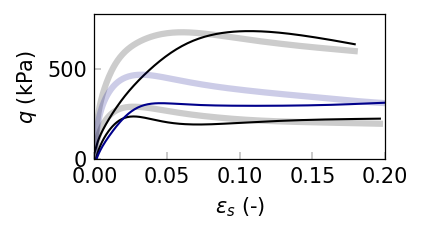

Epoch: 110 | Training Loss: 4.1192e-01 | validation loss: 3.1362e-01 | Elapsed Time Step: 0:00:02.790648
Epoch: 120 | Training Loss: 3.7316e-01 | validation loss: 3.0656e-01 | Elapsed Time Step: 0:00:02.703522
Epoch: 130 | Training Loss: 3.3402e-01 | validation loss: 3.1793e-01 | Elapsed Time Step: 0:00:02.540873
Epoch: 140 | Training Loss: 2.8265e-01 | validation loss: 3.2304e-01 | Elapsed Time Step: 0:00:02.527731
Epoch: 150 | Training Loss: 2.2461e-01 | validation loss: 3.2068e-01 | Elapsed Time Step: 0:00:02.736242
Epoch: 160 | Training Loss: 1.7082e-01 | validation loss: 3.1008e-01 | Elapsed Time Step: 0:00:02.805488
Epoch: 170 | Training Loss: 1.2961e-01 | validation loss: 2.9221e-01 | Elapsed Time Step: 0:00:02.599675
Epoch: 180 | Training Loss: 1.0241e-01 | validation loss: 2.8176e-01 | Elapsed Time Step: 0:00:02.617102
Epoch: 190 | Training Loss: 8.3187e-02 | validation loss: 2.8188e-01 | Elapsed Time Step: 0:00:02.576815
Epoch: 200 | Training Loss: 6.8488e-02 | validation los

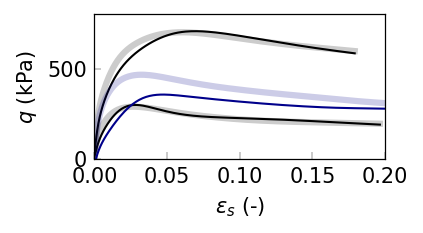

Epoch: 210 | Training Loss: 5.6970e-02 | validation loss: 2.7914e-01 | Elapsed Time Step: 0:00:02.818806
Epoch: 220 | Training Loss: 4.8716e-02 | validation loss: 2.7285e-01 | Elapsed Time Step: 0:00:02.592587
Epoch: 230 | Training Loss: 4.3062e-02 | validation loss: 2.5874e-01 | Elapsed Time Step: 0:00:02.585318
Epoch: 240 | Training Loss: 3.8659e-02 | validation loss: 2.3556e-01 | Elapsed Time Step: 0:00:02.734250
Epoch: 250 | Training Loss: 3.7269e-02 | validation loss: 1.8301e-01 | Elapsed Time Step: 0:00:03.082162
Epoch: 260 | Training Loss: 4.7939e-02 | validation loss: 2.2008e-01 | Elapsed Time Step: 0:00:02.649001
Epoch: 270 | Training Loss: 3.1944e-02 | validation loss: 1.2924e-01 | Elapsed Time Step: 0:00:04.762464
Epoch: 280 | Training Loss: 2.7953e-02 | validation loss: 1.1995e-01 | Elapsed Time Step: 0:00:03.335263
Epoch: 290 | Training Loss: 2.6106e-02 | validation loss: 1.0309e-01 | Elapsed Time Step: 0:00:02.649499
Epoch: 300 | Training Loss: 2.3473e-02 | validation los

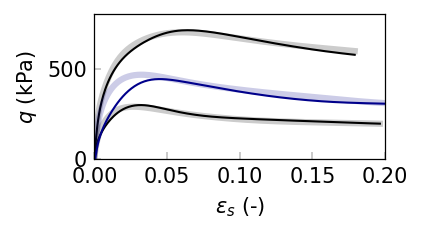

Epoch: 310 | Training Loss: 2.1213e-02 | validation loss: 6.7547e-02 | Elapsed Time Step: 0:00:03.202613
Epoch: 320 | Training Loss: 1.9024e-02 | validation loss: 5.8410e-02 | Elapsed Time Step: 0:00:02.881931
Epoch: 330 | Training Loss: 1.6917e-02 | validation loss: 5.2225e-02 | Elapsed Time Step: 0:00:02.985485
Epoch: 340 | Training Loss: 1.4968e-02 | validation loss: 5.0505e-02 | Elapsed Time Step: 0:00:02.756509
Epoch: 350 | Training Loss: 2.0416e-02 | validation loss: 6.1874e-02 | Elapsed Time Step: 0:00:02.744227
Epoch: 360 | Training Loss: 5.3846e-02 | validation loss: 4.4512e-02 | Elapsed Time Step: 0:00:02.842659
Epoch: 370 | Training Loss: 1.3899e-02 | validation loss: 4.0358e-02 | Elapsed Time Step: 0:00:02.689259
Epoch: 380 | Training Loss: 1.4629e-02 | validation loss: 3.5044e-02 | Elapsed Time Step: 0:00:02.992034
Epoch: 390 | Training Loss: 1.1046e-02 | validation loss: 3.0542e-02 | Elapsed Time Step: 0:00:02.681153
Epoch: 400 | Training Loss: 1.0429e-02 | validation los

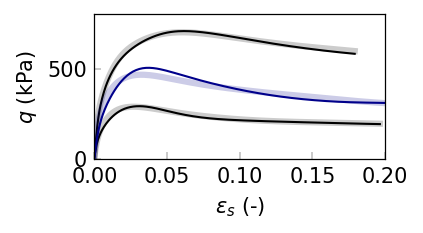

Epoch: 410 | Training Loss: 9.3392e-03 | validation loss: 3.2361e-02 | Elapsed Time Step: 0:00:02.764974
Epoch: 420 | Training Loss: 8.5022e-03 | validation loss: 3.2755e-02 | Elapsed Time Step: 0:00:02.703810
Epoch: 430 | Training Loss: 7.7702e-03 | validation loss: 3.5623e-02 | Elapsed Time Step: 0:00:02.738844
Epoch: 440 | Training Loss: 7.1293e-03 | validation loss: 3.7641e-02 | Elapsed Time Step: 0:00:02.739811
Epoch: 450 | Training Loss: 6.5927e-03 | validation loss: 3.9862e-02 | Elapsed Time Step: 0:00:02.644748
Epoch: 460 | Training Loss: 6.0892e-03 | validation loss: 4.2193e-02 | Elapsed Time Step: 0:00:02.943485
Epoch: 470 | Training Loss: 5.6419e-03 | validation loss: 4.4572e-02 | Elapsed Time Step: 0:00:02.627635
Epoch: 480 | Training Loss: 5.2404e-03 | validation loss: 4.6500e-02 | Elapsed Time Step: 0:00:02.701312
Epoch: 490 | Training Loss: 4.8735e-03 | validation loss: 4.8852e-02 | Elapsed Time Step: 0:00:02.891537
Epoch: 500 | Training Loss: 4.5478e-03 | validation los

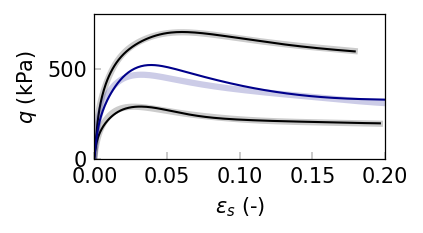

Epoch: 510 | Training Loss: 4.2648e-03 | validation loss: 5.2659e-02 | Elapsed Time Step: 0:00:02.861582
Epoch: 520 | Training Loss: 3.9950e-03 | validation loss: 5.3382e-02 | Elapsed Time Step: 0:00:03.155843
Epoch: 530 | Training Loss: 3.8491e-03 | validation loss: 5.3223e-02 | Elapsed Time Step: 0:00:03.263165
Epoch: 540 | Training Loss: 4.8729e-03 | validation loss: 4.5712e-02 | Elapsed Time Step: 0:00:03.704520
Epoch: 550 | Training Loss: 3.5439e-03 | validation loss: 4.8207e-02 | Elapsed Time Step: 0:00:02.988726
Epoch: 560 | Training Loss: 3.7562e-03 | validation loss: 4.7703e-02 | Elapsed Time Step: 0:00:03.623809
Epoch: 570 | Training Loss: 3.4454e-03 | validation loss: 4.4851e-02 | Elapsed Time Step: 0:00:03.616127
Epoch: 580 | Training Loss: 3.0852e-03 | validation loss: 4.2967e-02 | Elapsed Time Step: 0:00:03.135283
Epoch: 590 | Training Loss: 2.8631e-03 | validation loss: 4.0864e-02 | Elapsed Time Step: 0:00:02.872680
Epoch: 600 | Training Loss: 2.7133e-03 | validation los

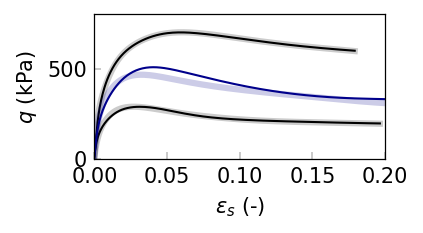

Epoch: 610 | Training Loss: 2.6491e-03 | validation loss: 4.0390e-02 | Elapsed Time Step: 0:00:02.904805
Epoch: 620 | Training Loss: 7.8526e-03 | validation loss: 3.1004e-02 | Elapsed Time Step: 0:00:02.970817
Epoch: 630 | Training Loss: 2.9703e-03 | validation loss: 3.3491e-02 | Elapsed Time Step: 0:00:02.782523
Epoch: 640 | Training Loss: 2.3247e-03 | validation loss: 3.3761e-02 | Elapsed Time Step: 0:00:02.638465
Epoch: 650 | Training Loss: 2.2677e-03 | validation loss: 3.2854e-02 | Elapsed Time Step: 0:00:02.567778
Epoch: 660 | Training Loss: 2.1919e-03 | validation loss: 3.2149e-02 | Elapsed Time Step: 0:00:02.734619
Epoch: 670 | Training Loss: 2.0460e-03 | validation loss: 3.0633e-02 | Elapsed Time Step: 0:00:02.604835
Epoch: 680 | Training Loss: 2.0104e-03 | validation loss: 3.1218e-02 | Elapsed Time Step: 0:00:03.382494
Epoch: 690 | Training Loss: 1.9428e-03 | validation loss: 2.9190e-02 | Elapsed Time Step: 0:00:02.767060
Epoch: 700 | Training Loss: 5.5275e-03 | validation los

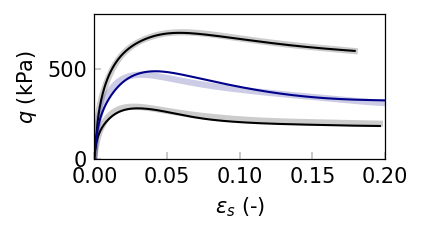

Epoch: 710 | Training Loss: 1.8836e-03 | validation loss: 2.5462e-02 | Elapsed Time Step: 0:00:02.858237
Epoch: 720 | Training Loss: 2.2283e-03 | validation loss: 2.7198e-02 | Elapsed Time Step: 0:00:02.607370
Epoch: 730 | Training Loss: 1.8504e-03 | validation loss: 2.4698e-02 | Elapsed Time Step: 0:00:02.564568
Epoch: 740 | Training Loss: 1.6361e-03 | validation loss: 2.2336e-02 | Elapsed Time Step: 0:00:02.727148
Epoch: 750 | Training Loss: 1.5678e-03 | validation loss: 2.2369e-02 | Elapsed Time Step: 0:00:02.760515
Epoch: 760 | Training Loss: 1.5215e-03 | validation loss: 2.1894e-02 | Elapsed Time Step: 0:00:02.717456
Epoch: 770 | Training Loss: 1.4699e-03 | validation loss: 2.1826e-02 | Elapsed Time Step: 0:00:02.598016
Epoch: 780 | Training Loss: 1.8188e-03 | validation loss: 2.3407e-02 | Elapsed Time Step: 0:00:02.726398
Epoch: 790 | Training Loss: 1.8554e-03 | validation loss: 1.7899e-02 | Elapsed Time Step: 0:00:02.564814
Epoch: 800 | Training Loss: 1.4618e-03 | validation los

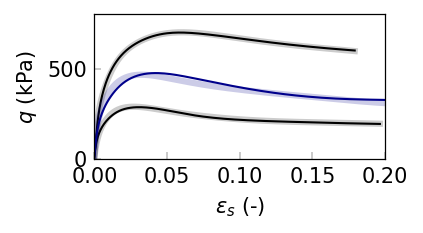

Epoch: 810 | Training Loss: 1.4394e-03 | validation loss: 1.6110e-02 | Elapsed Time Step: 0:00:02.719290
Epoch: 820 | Training Loss: 1.3920e-03 | validation loss: 1.5444e-02 | Elapsed Time Step: 0:00:02.677007
Epoch: 830 | Training Loss: 1.3215e-03 | validation loss: 1.5261e-02 | Elapsed Time Step: 0:00:03.266965
Epoch: 840 | Training Loss: 1.2577e-03 | validation loss: 1.5221e-02 | Elapsed Time Step: 0:00:02.693395
Epoch: 850 | Training Loss: 1.2337e-03 | validation loss: 1.5227e-02 | Elapsed Time Step: 0:00:02.502764
Epoch: 860 | Training Loss: 1.2162e-03 | validation loss: 1.5223e-02 | Elapsed Time Step: 0:00:02.568916
Epoch: 870 | Training Loss: 1.1777e-03 | validation loss: 1.4985e-02 | Elapsed Time Step: 0:00:02.517127
Epoch: 880 | Training Loss: 1.1549e-03 | validation loss: 1.4762e-02 | Elapsed Time Step: 0:00:02.527245
Epoch: 890 | Training Loss: 1.3172e-03 | validation loss: 1.4343e-02 | Elapsed Time Step: 0:00:02.519478
Epoch: 900 | Training Loss: 1.1353e-03 | validation los

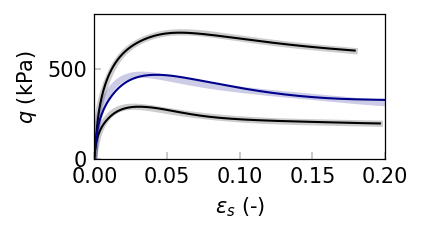

Epoch: 910 | Training Loss: 1.4108e-03 | validation loss: 1.5036e-02 | Elapsed Time Step: 0:00:02.729140
Epoch: 920 | Training Loss: 2.3024e-03 | validation loss: 1.5372e-02 | Elapsed Time Step: 0:00:02.646512
Epoch: 930 | Training Loss: 1.2792e-03 | validation loss: 1.3654e-02 | Elapsed Time Step: 0:00:02.628536
Epoch: 940 | Training Loss: 1.0392e-03 | validation loss: 1.3454e-02 | Elapsed Time Step: 0:00:02.582047
Epoch: 950 | Training Loss: 1.0151e-03 | validation loss: 1.3344e-02 | Elapsed Time Step: 0:00:02.709523
Epoch: 960 | Training Loss: 1.0958e-03 | validation loss: 1.3206e-02 | Elapsed Time Step: 0:00:02.636054
Epoch: 970 | Training Loss: 3.0691e-03 | validation loss: 1.3787e-02 | Elapsed Time Step: 0:00:02.678526
Epoch: 980 | Training Loss: 1.7149e-03 | validation loss: 1.3014e-02 | Elapsed Time Step: 0:00:02.595097
Epoch: 990 | Training Loss: 1.1563e-03 | validation loss: 1.2813e-02 | Elapsed Time Step: 0:00:02.619513
Epoch: 1000 | Training Loss: 9.4063e-04 | validation lo

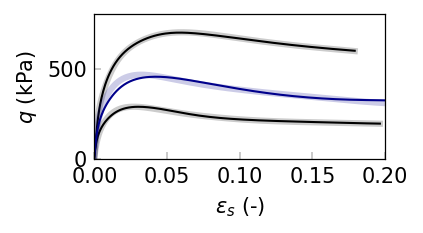

Epoch: 1010 | Training Loss: 9.4146e-04 | validation loss: 1.2380e-02 | Elapsed Time Step: 0:00:02.800443
Epoch: 1020 | Training Loss: 9.9598e-04 | validation loss: 1.2203e-02 | Elapsed Time Step: 0:00:02.562990
Epoch: 1030 | Training Loss: 9.4098e-04 | validation loss: 1.2518e-02 | Elapsed Time Step: 0:00:02.750717
Epoch: 1040 | Training Loss: 9.2968e-04 | validation loss: 1.2464e-02 | Elapsed Time Step: 0:00:02.551945
Epoch: 1050 | Training Loss: 9.5941e-04 | validation loss: 1.2108e-02 | Elapsed Time Step: 0:00:02.625873
Epoch: 1060 | Training Loss: 8.7109e-04 | validation loss: 1.2151e-02 | Elapsed Time Step: 0:00:02.573526
Epoch: 1070 | Training Loss: 8.5404e-04 | validation loss: 1.2163e-02 | Elapsed Time Step: 0:00:02.508848
Epoch: 1080 | Training Loss: 1.0772e-03 | validation loss: 1.2917e-02 | Elapsed Time Step: 0:00:02.728359
Epoch: 1090 | Training Loss: 1.3766e-03 | validation loss: 1.3009e-02 | Elapsed Time Step: 0:00:02.680669
Epoch: 1100 | Training Loss: 1.2715e-03 | vali

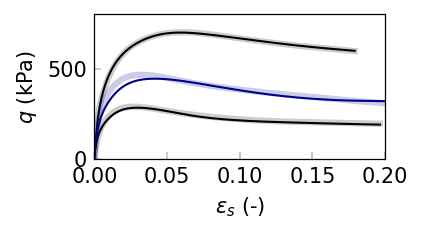

Epoch: 1110 | Training Loss: 8.4593e-04 | validation loss: 1.3191e-02 | Elapsed Time Step: 0:00:02.771766
Epoch: 1120 | Training Loss: 8.2187e-04 | validation loss: 1.3030e-02 | Elapsed Time Step: 0:00:02.627808
Epoch: 1130 | Training Loss: 8.0637e-04 | validation loss: 1.3204e-02 | Elapsed Time Step: 0:00:02.565823
Epoch: 1140 | Training Loss: 7.8840e-04 | validation loss: 1.3149e-02 | Elapsed Time Step: 0:00:02.573725
Epoch: 1150 | Training Loss: 7.6285e-04 | validation loss: 1.3209e-02 | Elapsed Time Step: 0:00:02.524871
Epoch: 1160 | Training Loss: 7.4801e-04 | validation loss: 1.3380e-02 | Elapsed Time Step: 0:00:02.498974
Epoch: 1170 | Training Loss: 7.3352e-04 | validation loss: 1.3493e-02 | Elapsed Time Step: 0:00:02.573652
Epoch: 1180 | Training Loss: 7.2289e-04 | validation loss: 1.3593e-02 | Elapsed Time Step: 0:00:02.614498
Epoch: 1190 | Training Loss: 7.1394e-04 | validation loss: 1.3767e-02 | Elapsed Time Step: 0:00:02.578208
Epoch: 1200 | Training Loss: 7.0574e-04 | vali

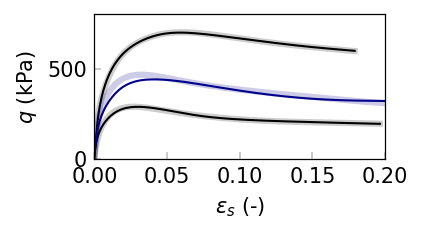

Epoch: 1210 | Training Loss: 6.9471e-04 | validation loss: 1.3674e-02 | Elapsed Time Step: 0:00:02.921495
Epoch: 1220 | Training Loss: 6.8923e-04 | validation loss: 1.3966e-02 | Elapsed Time Step: 0:00:02.756510
Epoch: 1230 | Training Loss: 6.7810e-04 | validation loss: 1.3696e-02 | Elapsed Time Step: 0:00:02.602231
Epoch: 1240 | Training Loss: 6.6337e-04 | validation loss: 1.3906e-02 | Elapsed Time Step: 0:00:02.710042
Epoch: 1250 | Training Loss: 6.8109e-04 | validation loss: 1.3367e-02 | Elapsed Time Step: 0:00:02.660559
Epoch: 1260 | Training Loss: 7.2457e-04 | validation loss: 1.3055e-02 | Elapsed Time Step: 0:00:02.824385
Epoch: 1270 | Training Loss: 1.8724e-03 | validation loss: 1.1254e-02 | Elapsed Time Step: 0:00:02.714661
Epoch: 1280 | Training Loss: 7.4935e-04 | validation loss: 1.5441e-02 | Elapsed Time Step: 0:00:02.687024
Epoch: 1290 | Training Loss: 7.1198e-04 | validation loss: 1.3615e-02 | Elapsed Time Step: 0:00:02.611813
Epoch: 1300 | Training Loss: 7.1626e-04 | vali

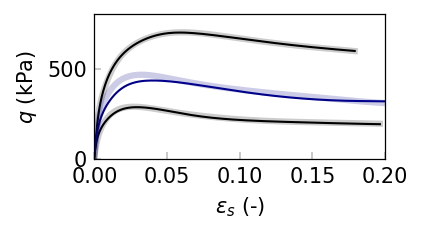

Epoch: 1310 | Training Loss: 6.3098e-04 | validation loss: 1.4597e-02 | Elapsed Time Step: 0:00:02.733968
Epoch: 1320 | Training Loss: 6.5346e-04 | validation loss: 1.6090e-02 | Elapsed Time Step: 0:00:02.608874
Epoch: 1330 | Training Loss: 8.7385e-04 | validation loss: 1.7328e-02 | Elapsed Time Step: 0:00:02.620265
Epoch: 1340 | Training Loss: 6.0405e-04 | validation loss: 1.4776e-02 | Elapsed Time Step: 0:00:02.654911
Epoch: 1350 | Training Loss: 5.7623e-04 | validation loss: 1.5330e-02 | Elapsed Time Step: 0:00:02.969851
Epoch: 1360 | Training Loss: 6.5086e-04 | validation loss: 1.6807e-02 | Elapsed Time Step: 0:00:02.706896
Epoch: 1370 | Training Loss: 6.5957e-04 | validation loss: 1.6926e-02 | Elapsed Time Step: 0:00:02.751321
Epoch: 1380 | Training Loss: 8.4171e-04 | validation loss: 1.3765e-02 | Elapsed Time Step: 0:00:02.813264
Epoch: 1390 | Training Loss: 1.9037e-03 | validation loss: 1.1710e-02 | Elapsed Time Step: 0:00:02.809883
Epoch: 1400 | Training Loss: 6.0506e-04 | vali

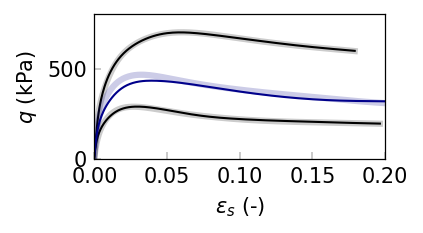

Epoch: 1410 | Training Loss: 8.2544e-04 | validation loss: 2.0147e-02 | Elapsed Time Step: 0:00:03.036684
Epoch: 1420 | Training Loss: 5.3139e-04 | validation loss: 1.8210e-02 | Elapsed Time Step: 0:00:02.945286
Epoch: 1430 | Training Loss: 6.0147e-04 | validation loss: 1.6885e-02 | Elapsed Time Step: 0:00:02.975282
Epoch: 1440 | Training Loss: 5.1931e-04 | validation loss: 1.8378e-02 | Elapsed Time Step: 0:00:03.071422
Epoch: 1450 | Training Loss: 5.1283e-04 | validation loss: 1.8428e-02 | Elapsed Time Step: 0:00:03.077391
Epoch: 1460 | Training Loss: 5.0536e-04 | validation loss: 1.7853e-02 | Elapsed Time Step: 0:00:02.808128
Epoch: 1470 | Training Loss: 4.9458e-04 | validation loss: 1.8121e-02 | Elapsed Time Step: 0:00:02.758109
Epoch: 1480 | Training Loss: 5.1452e-04 | validation loss: 1.9035e-02 | Elapsed Time Step: 0:00:02.677841
Epoch: 1490 | Training Loss: 5.6238e-04 | validation loss: 1.9596e-02 | Elapsed Time Step: 0:00:02.969578
Epoch: 1500 | Training Loss: 5.5946e-04 | vali

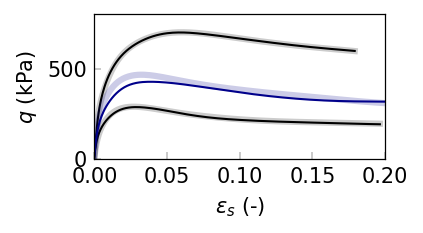

Epoch: 1510 | Training Loss: 1.1083e-03 | validation loss: 2.2656e-02 | Elapsed Time Step: 0:00:02.987687
Epoch: 1520 | Training Loss: 4.6647e-04 | validation loss: 1.8570e-02 | Elapsed Time Step: 0:00:03.448016
Epoch: 1530 | Training Loss: 4.5776e-04 | validation loss: 1.9100e-02 | Elapsed Time Step: 0:00:03.165039
Epoch: 1540 | Training Loss: 4.9095e-04 | validation loss: 2.0713e-02 | Elapsed Time Step: 0:00:03.340155
Epoch: 1550 | Training Loss: 4.6494e-04 | validation loss: 1.8942e-02 | Elapsed Time Step: 0:00:02.945011
Epoch: 1560 | Training Loss: 4.7023e-04 | validation loss: 2.0713e-02 | Elapsed Time Step: 0:00:03.349720
Epoch: 1570 | Training Loss: 4.5404e-04 | validation loss: 1.8785e-02 | Elapsed Time Step: 0:00:02.849578
Epoch: 1580 | Training Loss: 4.8767e-04 | validation loss: 1.8260e-02 | Elapsed Time Step: 0:00:03.076966
Epoch: 1590 | Training Loss: 6.0042e-04 | validation loss: 1.7328e-02 | Elapsed Time Step: 0:00:02.873267
Epoch: 1600 | Training Loss: 2.4480e-03 | vali

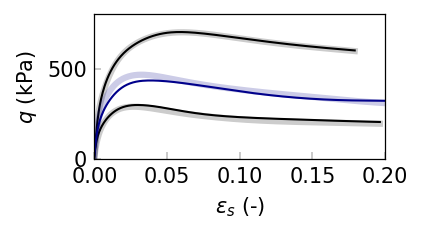

Epoch: 1610 | Training Loss: 8.0042e-04 | validation loss: 2.4125e-02 | Elapsed Time Step: 0:00:02.813989
Epoch: 1620 | Training Loss: 6.6503e-04 | validation loss: 1.8118e-02 | Elapsed Time Step: 0:00:02.900692
Epoch: 1630 | Training Loss: 6.6826e-04 | validation loss: 2.4995e-02 | Elapsed Time Step: 0:00:02.881153
Epoch: 1640 | Training Loss: 4.5313e-04 | validation loss: 2.0195e-02 | Elapsed Time Step: 0:00:02.820874
Epoch: 1650 | Training Loss: 4.2940e-04 | validation loss: 2.2728e-02 | Elapsed Time Step: 0:00:02.866114
Epoch: 1660 | Training Loss: 4.4940e-04 | validation loss: 2.0101e-02 | Elapsed Time Step: 0:00:03.136160
Epoch: 1670 | Training Loss: 4.3803e-04 | validation loss: 2.3063e-02 | Elapsed Time Step: 0:00:03.012638
Epoch: 1680 | Training Loss: 4.1219e-04 | validation loss: 2.2666e-02 | Elapsed Time Step: 0:00:02.714111
Epoch: 1690 | Training Loss: 4.7818e-04 | validation loss: 2.3575e-02 | Elapsed Time Step: 0:00:02.921966
Epoch: 1700 | Training Loss: 1.8641e-03 | vali

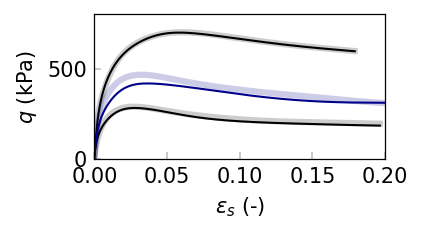

Epoch: 1710 | Training Loss: 5.9113e-04 | validation loss: 1.9179e-02 | Elapsed Time Step: 0:00:02.456669
Epoch: 1720 | Training Loss: 8.0935e-04 | validation loss: 2.7588e-02 | Elapsed Time Step: 0:00:02.280264
Epoch: 1730 | Training Loss: 4.5720e-04 | validation loss: 2.1841e-02 | Elapsed Time Step: 0:00:02.301737
Epoch: 1740 | Training Loss: 3.7735e-04 | validation loss: 2.4968e-02 | Elapsed Time Step: 0:00:02.246249
Epoch: 1750 | Training Loss: 3.5268e-04 | validation loss: 2.3822e-02 | Elapsed Time Step: 0:00:02.289861
Epoch: 1760 | Training Loss: 3.4699e-04 | validation loss: 2.3429e-02 | Elapsed Time Step: 0:00:02.450860
Epoch: 1770 | Training Loss: 3.4099e-04 | validation loss: 2.3026e-02 | Elapsed Time Step: 0:00:02.540213
Epoch: 1780 | Training Loss: 3.4051e-04 | validation loss: 2.3755e-02 | Elapsed Time Step: 0:00:02.458055
Epoch: 1790 | Training Loss: 3.5679e-04 | validation loss: 2.4292e-02 | Elapsed Time Step: 0:00:02.379387
Epoch: 1800 | Training Loss: 4.3670e-04 | vali

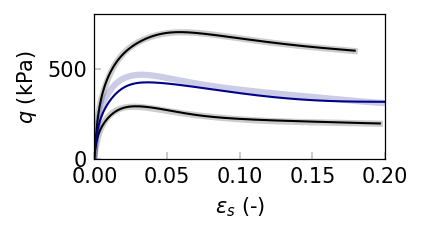

Epoch: 1810 | Training Loss: 6.0277e-04 | validation loss: 1.9664e-02 | Elapsed Time Step: 0:00:02.806715
Epoch: 1820 | Training Loss: 5.0483e-03 | validation loss: 1.1773e-02 | Elapsed Time Step: 0:00:02.551570
Epoch: 1830 | Training Loss: 3.5775e-04 | validation loss: 2.5549e-02 | Elapsed Time Step: 0:00:02.347700
Epoch: 1840 | Training Loss: 6.2329e-04 | validation loss: 3.0403e-02 | Elapsed Time Step: 0:00:02.252969
Epoch: 1850 | Training Loss: 3.9284e-04 | validation loss: 2.9496e-02 | Elapsed Time Step: 0:00:02.290112
Epoch: 1860 | Training Loss: 3.2913e-04 | validation loss: 2.7895e-02 | Elapsed Time Step: 0:00:02.374060
Epoch: 1870 | Training Loss: 3.1991e-04 | validation loss: 2.5954e-02 | Elapsed Time Step: 0:00:02.591290
Epoch: 1880 | Training Loss: 3.1615e-04 | validation loss: 2.7154e-02 | Elapsed Time Step: 0:00:02.641841
Epoch: 1890 | Training Loss: 3.2391e-04 | validation loss: 2.7481e-02 | Elapsed Time Step: 0:00:02.551417
Epoch: 1900 | Training Loss: 2.9855e-04 | vali

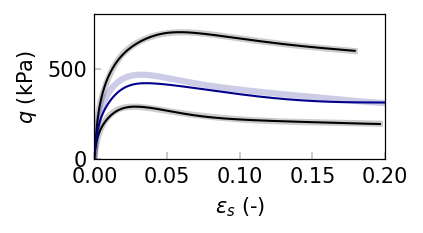

Epoch: 1910 | Training Loss: 2.9573e-04 | validation loss: 2.5880e-02 | Elapsed Time Step: 0:00:02.620093
Epoch: 1920 | Training Loss: 3.0111e-04 | validation loss: 2.6628e-02 | Elapsed Time Step: 0:00:02.358419
Epoch: 1930 | Training Loss: 3.4482e-04 | validation loss: 2.3992e-02 | Elapsed Time Step: 0:00:02.506917
Epoch: 1940 | Training Loss: 3.0443e-04 | validation loss: 2.4568e-02 | Elapsed Time Step: 0:00:02.499550
Epoch: 1950 | Training Loss: 2.8064e-04 | validation loss: 2.5606e-02 | Elapsed Time Step: 0:00:02.323132
Epoch: 1960 | Training Loss: 2.8403e-04 | validation loss: 2.6002e-02 | Elapsed Time Step: 0:00:02.344526
Epoch: 1970 | Training Loss: 3.8621e-04 | validation loss: 2.7802e-02 | Elapsed Time Step: 0:00:02.481898
Epoch: 1980 | Training Loss: 2.8807e-03 | validation loss: 3.9001e-02 | Elapsed Time Step: 0:00:02.338993
Epoch: 1990 | Training Loss: 1.9518e-03 | validation loss: 1.7590e-02 | Elapsed Time Step: 0:00:02.325924
Epoch: 2000 | Training Loss: 3.5563e-04 | vali

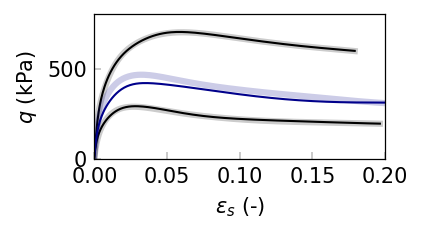

Epoch: 2010 | Training Loss: 3.2701e-04 | validation loss: 3.1218e-02 | Elapsed Time Step: 0:00:02.447238
Epoch: 2020 | Training Loss: 3.2400e-04 | validation loss: 3.0990e-02 | Elapsed Time Step: 0:00:02.397176
Epoch: 2030 | Training Loss: 3.1142e-04 | validation loss: 3.0249e-02 | Elapsed Time Step: 0:00:02.391817
Epoch: 2040 | Training Loss: 2.6611e-04 | validation loss: 2.8466e-02 | Elapsed Time Step: 0:00:02.307523
Epoch: 2050 | Training Loss: 2.6719e-04 | validation loss: 2.7965e-02 | Elapsed Time Step: 0:00:02.299050
Epoch: 2060 | Training Loss: 2.6180e-04 | validation loss: 2.8583e-02 | Elapsed Time Step: 0:00:02.332811
Epoch: 2070 | Training Loss: 2.5885e-04 | validation loss: 2.8070e-02 | Elapsed Time Step: 0:00:02.274244
Epoch: 2080 | Training Loss: 2.5729e-04 | validation loss: 2.8244e-02 | Elapsed Time Step: 0:00:02.297683
Epoch: 2090 | Training Loss: 2.5922e-04 | validation loss: 2.7234e-02 | Elapsed Time Step: 0:00:02.205250
Epoch: 2100 | Training Loss: 6.3635e-04 | vali

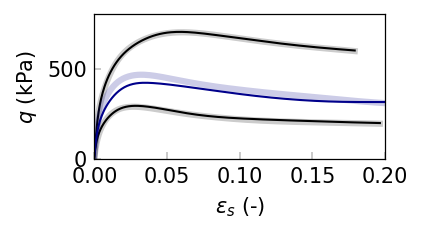

Epoch: 2110 | Training Loss: 4.3850e-04 | validation loss: 2.4322e-02 | Elapsed Time Step: 0:00:02.522198
Epoch: 2120 | Training Loss: 3.2491e-04 | validation loss: 3.0315e-02 | Elapsed Time Step: 0:00:02.313717
Epoch: 2130 | Training Loss: 2.6568e-04 | validation loss: 2.9678e-02 | Elapsed Time Step: 0:00:02.368793
Epoch: 2140 | Training Loss: 2.4741e-04 | validation loss: 2.7904e-02 | Elapsed Time Step: 0:00:02.393251
Epoch: 2150 | Training Loss: 2.4358e-04 | validation loss: 2.7669e-02 | Elapsed Time Step: 0:00:02.466356
Epoch: 2160 | Training Loss: 2.7657e-04 | validation loss: 2.9475e-02 | Elapsed Time Step: 0:00:02.331080
Epoch: 2170 | Training Loss: 4.3547e-03 | validation loss: 4.7629e-02 | Elapsed Time Step: 0:00:02.287162
Epoch: 2180 | Training Loss: 1.2819e-03 | validation loss: 2.1223e-02 | Elapsed Time Step: 0:00:02.181875
Epoch: 2190 | Training Loss: 7.9383e-04 | validation loss: 2.4711e-02 | Elapsed Time Step: 0:00:02.345087
Epoch: 2200 | Training Loss: 3.8212e-04 | vali

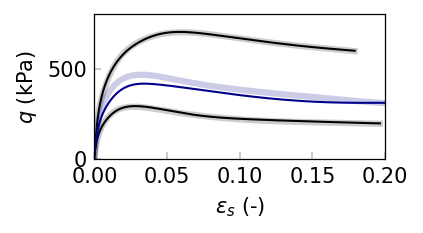

Epoch: 2210 | Training Loss: 2.4098e-04 | validation loss: 3.1462e-02 | Elapsed Time Step: 0:00:02.451568
Epoch: 2220 | Training Loss: 2.3781e-04 | validation loss: 3.1208e-02 | Elapsed Time Step: 0:00:02.172951
Epoch: 2230 | Training Loss: 2.3336e-04 | validation loss: 3.1568e-02 | Elapsed Time Step: 0:00:02.562312
Epoch: 2240 | Training Loss: 2.3314e-04 | validation loss: 3.0955e-02 | Elapsed Time Step: 0:00:02.211745
Epoch: 2250 | Training Loss: 2.6002e-04 | validation loss: 3.2431e-02 | Elapsed Time Step: 0:00:02.247770
Epoch: 2260 | Training Loss: 2.2721e-04 | validation loss: 3.0917e-02 | Elapsed Time Step: 0:00:02.287481
Epoch: 2270 | Training Loss: 2.2745e-04 | validation loss: 3.0236e-02 | Elapsed Time Step: 0:00:02.167229
Epoch: 2280 | Training Loss: 2.2421e-04 | validation loss: 3.0666e-02 | Elapsed Time Step: 0:00:02.081983
Epoch: 2290 | Training Loss: 2.2202e-04 | validation loss: 3.0102e-02 | Elapsed Time Step: 0:00:02.144870
Epoch: 2300 | Training Loss: 2.1981e-04 | vali

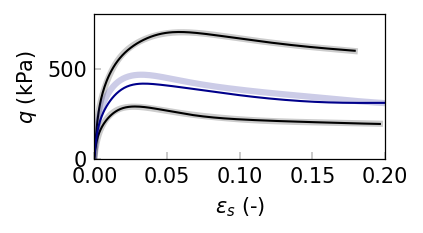

Epoch: 2310 | Training Loss: 2.1827e-04 | validation loss: 3.0142e-02 | Elapsed Time Step: 0:00:02.193589
Epoch: 2320 | Training Loss: 2.1784e-04 | validation loss: 3.0178e-02 | Elapsed Time Step: 0:00:02.101902
Epoch: 2330 | Training Loss: 2.6877e-04 | validation loss: 3.1760e-02 | Elapsed Time Step: 0:00:02.192770
Epoch: 2340 | Training Loss: 3.7580e-03 | validation loss: 4.8675e-02 | Elapsed Time Step: 0:00:02.115635
Epoch: 2350 | Training Loss: 2.2133e-03 | validation loss: 1.9667e-02 | Elapsed Time Step: 0:00:02.167740
Epoch: 2360 | Training Loss: 8.7825e-04 | validation loss: 2.5621e-02 | Elapsed Time Step: 0:00:02.291696
Epoch: 2370 | Training Loss: 3.6061e-04 | validation loss: 3.1161e-02 | Elapsed Time Step: 0:00:02.369858
Epoch: 2380 | Training Loss: 2.5595e-04 | validation loss: 3.2153e-02 | Elapsed Time Step: 0:00:02.301661
Epoch: 2390 | Training Loss: 2.1958e-04 | validation loss: 3.2745e-02 | Elapsed Time Step: 0:00:02.418359
Epoch: 2400 | Training Loss: 2.1950e-04 | vali

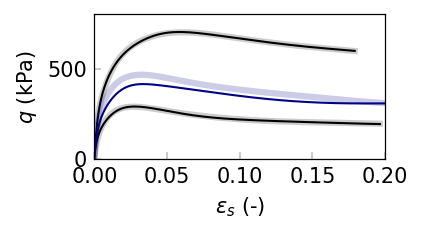

Epoch: 2410 | Training Loss: 2.1088e-04 | validation loss: 3.3418e-02 | Elapsed Time Step: 0:00:02.683774
Epoch: 2420 | Training Loss: 2.1263e-04 | validation loss: 3.2402e-02 | Elapsed Time Step: 0:00:02.384734
Epoch: 2430 | Training Loss: 2.0723e-04 | validation loss: 3.2920e-02 | Elapsed Time Step: 0:00:02.409092
Epoch: 2440 | Training Loss: 2.0615e-04 | validation loss: 3.2818e-02 | Elapsed Time Step: 0:00:02.347266
Epoch: 2450 | Training Loss: 2.0655e-04 | validation loss: 3.1980e-02 | Elapsed Time Step: 0:00:02.445466
Epoch: 2460 | Training Loss: 2.1351e-04 | validation loss: 3.1576e-02 | Elapsed Time Step: 0:00:02.372851
Epoch: 2470 | Training Loss: 3.0983e-04 | validation loss: 3.5208e-02 | Elapsed Time Step: 0:00:02.382123
Epoch: 2480 | Training Loss: 3.8860e-04 | validation loss: 3.5994e-02 | Elapsed Time Step: 0:00:02.340370
Epoch: 2490 | Training Loss: 2.3241e-04 | validation loss: 3.3857e-02 | Elapsed Time Step: 0:00:02.283542
Epoch: 2500 | Training Loss: 5.2655e-04 | vali

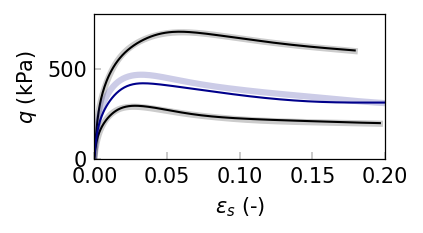

Epoch: 2510 | Training Loss: 2.6619e-04 | validation loss: 3.4843e-02 | Elapsed Time Step: 0:00:02.469715
Epoch: 2520 | Training Loss: 2.0743e-04 | validation loss: 3.1287e-02 | Elapsed Time Step: 0:00:02.284878
Epoch: 2530 | Training Loss: 2.7035e-04 | validation loss: 2.9822e-02 | Elapsed Time Step: 0:00:02.290656
Epoch: 2540 | Training Loss: 3.3988e-04 | validation loss: 3.5843e-02 | Elapsed Time Step: 0:00:02.371398
Epoch: 2550 | Training Loss: 2.4423e-04 | validation loss: 3.0089e-02 | Elapsed Time Step: 0:00:02.313172
Epoch: 2560 | Training Loss: 6.7633e-04 | validation loss: 2.6071e-02 | Elapsed Time Step: 0:00:02.439366
Epoch: 2570 | Training Loss: 1.8276e-03 | validation loss: 2.1652e-02 | Elapsed Time Step: 0:00:02.252315
Epoch: 2580 | Training Loss: 6.3683e-04 | validation loss: 2.7902e-02 | Elapsed Time Step: 0:00:02.098283
Epoch: 2590 | Training Loss: 2.0238e-04 | validation loss: 3.6746e-02 | Elapsed Time Step: 0:00:02.046830
Epoch: 2600 | Training Loss: 2.5439e-04 | vali

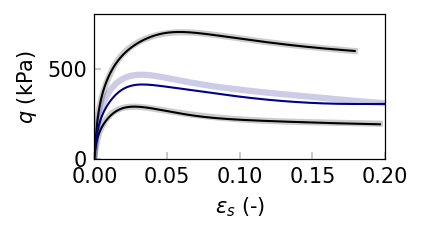

Epoch: 2610 | Training Loss: 2.3514e-04 | validation loss: 3.7492e-02 | Elapsed Time Step: 0:00:02.181559
Epoch: 2620 | Training Loss: 1.9683e-04 | validation loss: 3.6119e-02 | Elapsed Time Step: 0:00:02.007667
Epoch: 2630 | Training Loss: 1.9564e-04 | validation loss: 3.4891e-02 | Elapsed Time Step: 0:00:02.109572
Epoch: 2640 | Training Loss: 1.9186e-04 | validation loss: 3.4898e-02 | Elapsed Time Step: 0:00:02.102766
Epoch: 2650 | Training Loss: 1.9101e-04 | validation loss: 3.5250e-02 | Elapsed Time Step: 0:00:02.035742
Epoch: 2660 | Training Loss: 1.8931e-04 | validation loss: 3.4652e-02 | Elapsed Time Step: 0:00:02.046911
Epoch: 2670 | Training Loss: 1.8727e-04 | validation loss: 3.4763e-02 | Elapsed Time Step: 0:00:02.014813
Epoch: 2680 | Training Loss: 1.8634e-04 | validation loss: 3.4465e-02 | Elapsed Time Step: 0:00:02.151566
Epoch: 2690 | Training Loss: 1.8536e-04 | validation loss: 3.4330e-02 | Elapsed Time Step: 0:00:02.126114
Epoch: 2700 | Training Loss: 1.8439e-04 | vali

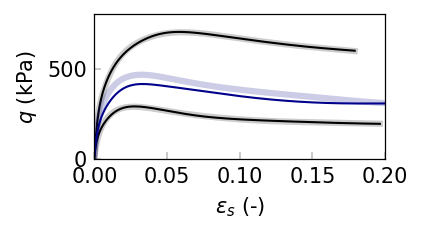

Epoch: 2710 | Training Loss: 1.8359e-04 | validation loss: 3.4149e-02 | Elapsed Time Step: 0:00:02.291935
Epoch: 2720 | Training Loss: 1.8334e-04 | validation loss: 3.4232e-02 | Elapsed Time Step: 0:00:02.126212
Epoch: 2730 | Training Loss: 2.3301e-04 | validation loss: 3.6109e-02 | Elapsed Time Step: 0:00:02.202176
Epoch: 2740 | Training Loss: 6.3046e-03 | validation loss: 6.3062e-02 | Elapsed Time Step: 0:00:02.108148
Epoch: 2750 | Training Loss: 2.2316e-04 | validation loss: 3.4083e-02 | Elapsed Time Step: 0:00:02.189483
Epoch: 2760 | Training Loss: 2.7621e-04 | validation loss: 4.1854e-02 | Elapsed Time Step: 0:00:02.077412
Epoch: 2770 | Training Loss: 4.2164e-04 | validation loss: 4.6494e-02 | Elapsed Time Step: 0:00:02.262092
Epoch: 2780 | Training Loss: 2.2261e-04 | validation loss: 4.1433e-02 | Elapsed Time Step: 0:00:02.395169
Epoch: 2790 | Training Loss: 1.9386e-04 | validation loss: 3.9773e-02 | Elapsed Time Step: 0:00:02.428264
Epoch: 2800 | Training Loss: 1.8791e-04 | vali

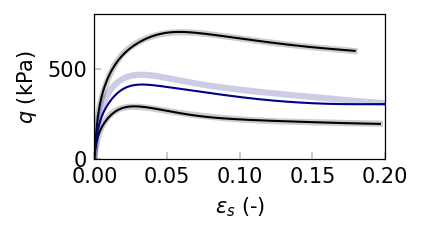

Epoch: 2810 | Training Loss: 1.8563e-04 | validation loss: 3.8911e-02 | Elapsed Time Step: 0:00:02.132192
Epoch: 2820 | Training Loss: 1.8323e-04 | validation loss: 3.8623e-02 | Elapsed Time Step: 0:00:02.024237
Epoch: 2830 | Training Loss: 1.8181e-04 | validation loss: 3.8552e-02 | Elapsed Time Step: 0:00:02.052166
Epoch: 2840 | Training Loss: 1.8141e-04 | validation loss: 3.8407e-02 | Elapsed Time Step: 0:00:02.072417
Epoch: 2850 | Training Loss: 1.8019e-04 | validation loss: 3.7790e-02 | Elapsed Time Step: 0:00:02.172117
Epoch: 2860 | Training Loss: 1.7860e-04 | validation loss: 3.7839e-02 | Elapsed Time Step: 0:00:02.387739
Epoch: 2870 | Training Loss: 1.7939e-04 | validation loss: 3.7447e-02 | Elapsed Time Step: 0:00:02.214120
Epoch: 2880 | Training Loss: 1.7729e-04 | validation loss: 3.7596e-02 | Elapsed Time Step: 0:00:02.130861
Epoch: 2890 | Training Loss: 1.7693e-04 | validation loss: 3.7892e-02 | Elapsed Time Step: 0:00:02.165064
Epoch: 2900 | Training Loss: 1.7493e-04 | vali

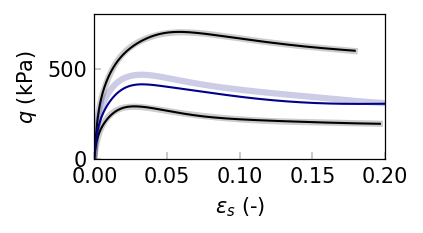

Epoch: 2910 | Training Loss: 1.7400e-04 | validation loss: 3.7468e-02 | Elapsed Time Step: 0:00:02.543793
Epoch: 2920 | Training Loss: 1.7312e-04 | validation loss: 3.7163e-02 | Elapsed Time Step: 0:00:02.344847
Epoch: 2930 | Training Loss: 1.7239e-04 | validation loss: 3.7115e-02 | Elapsed Time Step: 0:00:02.556557
Epoch: 2940 | Training Loss: 1.7173e-04 | validation loss: 3.7050e-02 | Elapsed Time Step: 0:00:02.762372
Epoch: 2950 | Training Loss: 1.7107e-04 | validation loss: 3.6912e-02 | Elapsed Time Step: 0:00:03.345265
Epoch: 2960 | Training Loss: 1.7044e-04 | validation loss: 3.6795e-02 | Elapsed Time Step: 0:00:03.116461
Epoch: 2970 | Training Loss: 1.6997e-04 | validation loss: 3.6611e-02 | Elapsed Time Step: 0:00:02.723067
Epoch: 2980 | Training Loss: 1.7870e-04 | validation loss: 3.5662e-02 | Elapsed Time Step: 0:00:02.179034
Epoch: 2990 | Training Loss: 1.4144e-03 | validation loss: 2.6220e-02 | Elapsed Time Step: 0:00:02.272562
Epoch: 3000 | Training Loss: 1.1446e-03 | vali

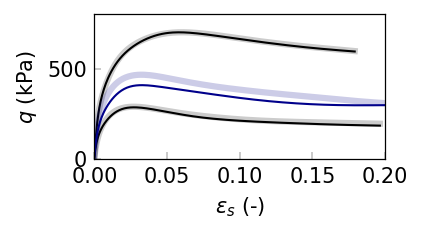

Epoch: 3010 | Training Loss: 4.8291e-04 | validation loss: 4.6020e-02 | Elapsed Time Step: 0:00:02.975291
Epoch: 3020 | Training Loss: 5.4997e-04 | validation loss: 5.1180e-02 | Elapsed Time Step: 0:00:02.429881
Epoch: 3030 | Training Loss: 2.7624e-04 | validation loss: 4.6038e-02 | Elapsed Time Step: 0:00:02.466689
Epoch: 3040 | Training Loss: 1.9607e-04 | validation loss: 4.0571e-02 | Elapsed Time Step: 0:00:02.259076
Epoch: 3050 | Training Loss: 2.6641e-04 | validation loss: 3.8770e-02 | Elapsed Time Step: 0:00:02.181289
Epoch: 3060 | Training Loss: 1.9833e-04 | validation loss: 4.0012e-02 | Elapsed Time Step: 0:00:02.195819
Epoch: 3070 | Training Loss: 1.7925e-04 | validation loss: 4.0584e-02 | Elapsed Time Step: 0:00:02.168558
Epoch: 3080 | Training Loss: 1.7395e-04 | validation loss: 4.0761e-02 | Elapsed Time Step: 0:00:02.103893
Epoch: 3090 | Training Loss: 1.7153e-04 | validation loss: 4.0788e-02 | Elapsed Time Step: 0:00:02.077075
Epoch: 3100 | Training Loss: 1.6932e-04 | vali

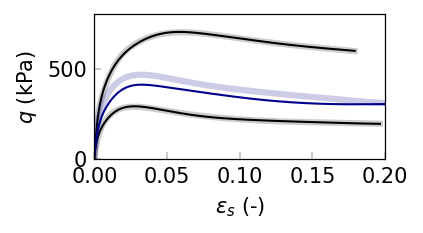

Epoch: 3110 | Training Loss: 1.7882e-04 | validation loss: 4.2057e-02 | Elapsed Time Step: 0:00:02.633194
Epoch: 3120 | Training Loss: 1.6838e-04 | validation loss: 4.0205e-02 | Elapsed Time Step: 0:00:02.438673
Epoch: 3130 | Training Loss: 1.6647e-04 | validation loss: 4.0395e-02 | Elapsed Time Step: 0:00:02.588189
Epoch: 3140 | Training Loss: 1.6600e-04 | validation loss: 4.0746e-02 | Elapsed Time Step: 0:00:02.327801
Epoch: 3150 | Training Loss: 1.6441e-04 | validation loss: 4.0339e-02 | Elapsed Time Step: 0:00:02.322786
Epoch: 3160 | Training Loss: 1.6377e-04 | validation loss: 4.0320e-02 | Elapsed Time Step: 0:00:02.437813
Epoch: 3170 | Training Loss: 1.6292e-04 | validation loss: 4.0344e-02 | Elapsed Time Step: 0:00:02.681613
Epoch: 3180 | Training Loss: 1.6215e-04 | validation loss: 4.0132e-02 | Elapsed Time Step: 0:00:02.097606
Epoch: 3190 | Training Loss: 1.6151e-04 | validation loss: 4.0112e-02 | Elapsed Time Step: 0:00:02.295315
Epoch: 3200 | Training Loss: 1.6090e-04 | vali

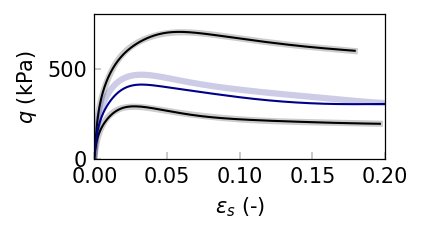

Epoch: 3210 | Training Loss: 1.6032e-04 | validation loss: 3.9894e-02 | Elapsed Time Step: 0:00:02.374881
Epoch: 3220 | Training Loss: 1.5975e-04 | validation loss: 3.9817e-02 | Elapsed Time Step: 0:00:02.099332
Epoch: 3230 | Training Loss: 1.5919e-04 | validation loss: 3.9733e-02 | Elapsed Time Step: 0:00:02.281824
Epoch: 3240 | Training Loss: 1.5866e-04 | validation loss: 3.9639e-02 | Elapsed Time Step: 0:00:02.336410
Epoch: 3250 | Training Loss: 1.5840e-04 | validation loss: 3.9404e-02 | Elapsed Time Step: 0:00:02.274061
Epoch: 3260 | Training Loss: 2.1408e-04 | validation loss: 3.6963e-02 | Elapsed Time Step: 0:00:02.192577
Epoch: 3270 | Training Loss: 1.0334e-02 | validation loss: 1.3738e-02 | Elapsed Time Step: 0:00:02.293210
Epoch: 3280 | Training Loss: 1.7405e-03 | validation loss: 2.8629e-02 | Elapsed Time Step: 0:00:02.502425
Epoch: 3290 | Training Loss: 8.3878e-04 | validation loss: 3.6903e-02 | Elapsed Time Step: 0:00:02.230195
Epoch: 3300 | Training Loss: 2.3230e-04 | vali

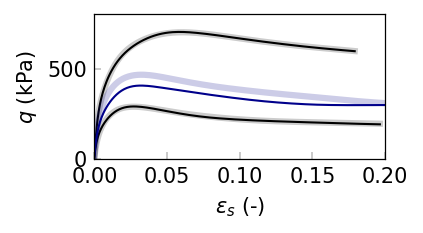

Epoch: 3310 | Training Loss: 2.4460e-04 | validation loss: 4.8906e-02 | Elapsed Time Step: 0:00:02.174282
Epoch: 3320 | Training Loss: 1.8068e-04 | validation loss: 4.4527e-02 | Elapsed Time Step: 0:00:02.072296
Epoch: 3330 | Training Loss: 1.7797e-04 | validation loss: 4.4237e-02 | Elapsed Time Step: 0:00:02.034052
Epoch: 3340 | Training Loss: 1.6411e-04 | validation loss: 4.5182e-02 | Elapsed Time Step: 0:00:02.080767
Epoch: 3350 | Training Loss: 1.6410e-04 | validation loss: 4.5307e-02 | Elapsed Time Step: 0:00:02.011586
Epoch: 3360 | Training Loss: 1.6196e-04 | validation loss: 4.4992e-02 | Elapsed Time Step: 0:00:02.011969
Epoch: 3370 | Training Loss: 1.6020e-04 | validation loss: 4.4631e-02 | Elapsed Time Step: 0:00:02.030655
Epoch: 3380 | Training Loss: 1.5901e-04 | validation loss: 4.4343e-02 | Elapsed Time Step: 0:00:02.175602
Epoch: 3390 | Training Loss: 1.5802e-04 | validation loss: 4.4192e-02 | Elapsed Time Step: 0:00:02.067364
Epoch: 3400 | Training Loss: 1.5713e-04 | vali

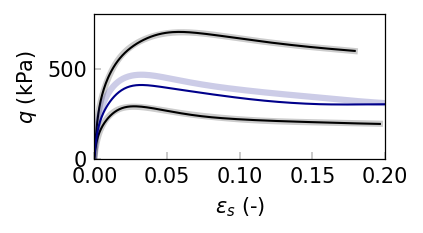

Epoch: 3410 | Training Loss: 1.5631e-04 | validation loss: 4.3891e-02 | Elapsed Time Step: 0:00:02.194126
Epoch: 3420 | Training Loss: 1.5555e-04 | validation loss: 4.3758e-02 | Elapsed Time Step: 0:00:02.033968
Epoch: 3430 | Training Loss: 1.5487e-04 | validation loss: 4.3631e-02 | Elapsed Time Step: 0:00:02.039313
Epoch: 3440 | Training Loss: 1.5426e-04 | validation loss: 4.3519e-02 | Elapsed Time Step: 0:00:02.037575
Epoch: 3450 | Training Loss: 1.5364e-04 | validation loss: 4.3424e-02 | Elapsed Time Step: 0:00:02.001934
Epoch: 3460 | Training Loss: 1.5301e-04 | validation loss: 4.3327e-02 | Elapsed Time Step: 0:00:01.991046
Epoch: 3470 | Training Loss: 1.5241e-04 | validation loss: 4.3222e-02 | Elapsed Time Step: 0:00:02.093735
Epoch: 3480 | Training Loss: 1.5183e-04 | validation loss: 4.3137e-02 | Elapsed Time Step: 0:00:02.135479
Epoch: 3490 | Training Loss: 1.5127e-04 | validation loss: 4.3051e-02 | Elapsed Time Step: 0:00:02.330372
Epoch: 3500 | Training Loss: 1.5071e-04 | vali

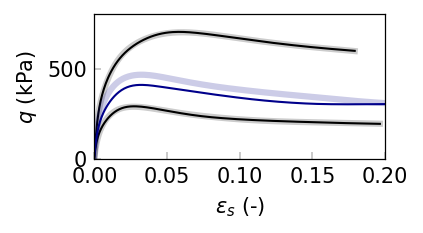

Epoch: 3510 | Training Loss: 1.5017e-04 | validation loss: 4.2881e-02 | Elapsed Time Step: 0:00:02.370056
Epoch: 3520 | Training Loss: 1.4967e-04 | validation loss: 4.2814e-02 | Elapsed Time Step: 0:00:02.148600
Epoch: 3530 | Training Loss: 1.4913e-04 | validation loss: 4.2736e-02 | Elapsed Time Step: 0:00:02.099260
Epoch: 3540 | Training Loss: 1.4863e-04 | validation loss: 4.2645e-02 | Elapsed Time Step: 0:00:02.069435
Epoch: 3550 | Training Loss: 1.4823e-04 | validation loss: 4.2474e-02 | Elapsed Time Step: 0:00:02.131679
Epoch: 3560 | Training Loss: 1.5286e-04 | validation loss: 4.1696e-02 | Elapsed Time Step: 0:00:02.148942
Epoch: 3570 | Training Loss: 7.3426e-04 | validation loss: 3.4112e-02 | Elapsed Time Step: 0:00:02.040324
Epoch: 3580 | Training Loss: 4.0479e-04 | validation loss: 3.7200e-02 | Elapsed Time Step: 0:00:02.076532
Epoch: 3590 | Training Loss: 4.0611e-04 | validation loss: 3.9450e-02 | Elapsed Time Step: 0:00:02.069364
Epoch: 3600 | Training Loss: 1.6518e-04 | vali

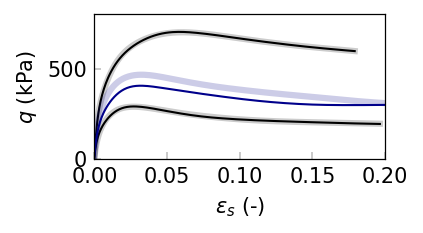

Epoch: 3610 | Training Loss: 2.3558e-04 | validation loss: 5.1555e-02 | Elapsed Time Step: 0:00:02.290238
Epoch: 3620 | Training Loss: 2.0231e-04 | validation loss: 5.0065e-02 | Elapsed Time Step: 0:00:02.019966
Epoch: 3630 | Training Loss: 1.6417e-04 | validation loss: 4.8875e-02 | Elapsed Time Step: 0:00:02.091055
Epoch: 3640 | Training Loss: 1.5373e-04 | validation loss: 4.7639e-02 | Elapsed Time Step: 0:00:02.002809
Epoch: 3650 | Training Loss: 1.5020e-04 | validation loss: 4.6970e-02 | Elapsed Time Step: 0:00:02.023217
Epoch: 3660 | Training Loss: 1.4864e-04 | validation loss: 4.6725e-02 | Elapsed Time Step: 0:00:02.136882
Epoch: 3670 | Training Loss: 1.4738e-04 | validation loss: 4.6540e-02 | Elapsed Time Step: 0:00:02.042003
Epoch: 3680 | Training Loss: 1.4644e-04 | validation loss: 4.6308e-02 | Elapsed Time Step: 0:00:01.994908
Epoch: 3690 | Training Loss: 1.4559e-04 | validation loss: 4.6083e-02 | Elapsed Time Step: 0:00:01.991735
Epoch: 3700 | Training Loss: 1.4490e-04 | vali

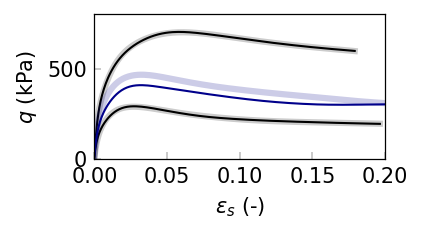

Epoch: 3710 | Training Loss: 1.4425e-04 | validation loss: 4.5762e-02 | Elapsed Time Step: 0:00:02.167175
Epoch: 3720 | Training Loss: 1.4365e-04 | validation loss: 4.5691e-02 | Elapsed Time Step: 0:00:02.018674
Epoch: 3730 | Training Loss: 1.4313e-04 | validation loss: 4.5559e-02 | Elapsed Time Step: 0:00:02.022645
Epoch: 3740 | Training Loss: 1.4261e-04 | validation loss: 4.5438e-02 | Elapsed Time Step: 0:00:01.983323
Epoch: 3750 | Training Loss: 1.4208e-04 | validation loss: 4.5337e-02 | Elapsed Time Step: 0:00:02.087196
Epoch: 3760 | Training Loss: 1.4156e-04 | validation loss: 4.5231e-02 | Elapsed Time Step: 0:00:01.997959
Epoch: 3770 | Training Loss: 1.4105e-04 | validation loss: 4.5136e-02 | Elapsed Time Step: 0:00:02.030914
Epoch: 3780 | Training Loss: 1.4056e-04 | validation loss: 4.5047e-02 | Elapsed Time Step: 0:00:02.070892
Epoch: 3790 | Training Loss: 1.4008e-04 | validation loss: 4.4963e-02 | Elapsed Time Step: 0:00:02.024210
Epoch: 3800 | Training Loss: 1.3961e-04 | vali

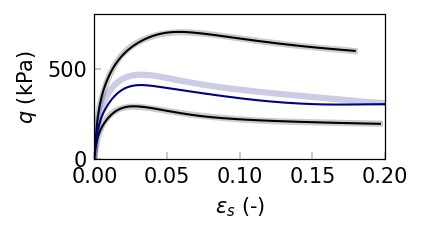

Epoch: 3810 | Training Loss: 1.3914e-04 | validation loss: 4.4804e-02 | Elapsed Time Step: 0:00:02.454188
Epoch: 3820 | Training Loss: 1.3869e-04 | validation loss: 4.4734e-02 | Elapsed Time Step: 0:00:02.147802
Epoch: 3830 | Training Loss: 1.3827e-04 | validation loss: 4.4709e-02 | Elapsed Time Step: 0:00:02.037501
Epoch: 3840 | Training Loss: 1.4186e-04 | validation loss: 4.5354e-02 | Elapsed Time Step: 0:00:02.032820
Epoch: 3850 | Training Loss: 1.6059e-03 | validation loss: 6.0632e-02 | Elapsed Time Step: 0:00:02.096075
Epoch: 3860 | Training Loss: 4.9790e-03 | validation loss: 2.3136e-02 | Elapsed Time Step: 0:00:02.025052
Epoch: 3870 | Training Loss: 8.4847e-04 | validation loss: 3.9533e-02 | Elapsed Time Step: 0:00:02.105772
Epoch: 3880 | Training Loss: 5.9998e-04 | validation loss: 6.4270e-02 | Elapsed Time Step: 0:00:02.081914
Epoch: 3890 | Training Loss: 1.7233e-04 | validation loss: 5.0067e-02 | Elapsed Time Step: 0:00:02.079624
Epoch: 3900 | Training Loss: 1.6997e-04 | vali

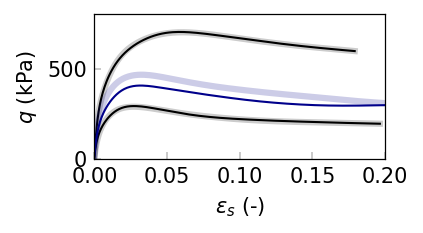

Epoch: 3910 | Training Loss: 1.6273e-04 | validation loss: 5.3131e-02 | Elapsed Time Step: 0:00:02.292710
Epoch: 3920 | Training Loss: 1.4532e-04 | validation loss: 5.1257e-02 | Elapsed Time Step: 0:00:02.141328
Epoch: 3930 | Training Loss: 1.4296e-04 | validation loss: 5.0442e-02 | Elapsed Time Step: 0:00:01.998100
Epoch: 3940 | Training Loss: 1.4093e-04 | validation loss: 5.0271e-02 | Elapsed Time Step: 0:00:02.033615
Epoch: 3950 | Training Loss: 1.3958e-04 | validation loss: 5.0216e-02 | Elapsed Time Step: 0:00:02.028498
Epoch: 3960 | Training Loss: 1.3837e-04 | validation loss: 5.0044e-02 | Elapsed Time Step: 0:00:02.005058
Epoch: 3970 | Training Loss: 1.3848e-04 | validation loss: 4.9754e-02 | Elapsed Time Step: 0:00:02.104646
Epoch: 3980 | Training Loss: 1.3798e-04 | validation loss: 4.9615e-02 | Elapsed Time Step: 0:00:01.980243
Epoch: 3990 | Training Loss: 1.3713e-04 | validation loss: 4.9456e-02 | Elapsed Time Step: 0:00:02.043552


In [9]:
# Track starting time for performance monitoring
time_now = datetime.now()
t_0 = datetime.now()

# Training loop
for epoch in range(1, n_epochs):
    # Zero gradients before backward pass
    optimizer.zero_grad()

    # Extract initial elastic strain (denormalized)
    initial_epsilon_el = NICE_network.DeNormalize(NICE_network.initial_elastic_strain,
                                                  NICE_network.prm_strain_elastic)

    # Define the initial conditions for integration
    initial_conditions = torch.cat((initial_epsilon_el, initial_density, initial_dissipation), -1)

    # Compute the initial stress prediction from the NICE model
    stress_e, p_T, predicted_initial_stress = NICE_network.stress([initial_epsilon_el, initial_density])

    # Forward pass: Integrate the ODE system using the NICE network
    predictions = NICE_network.integrate(initial_conditions, t, id_protocol_train_val)
    predicted_svars, predicted_stress, predicted_dissipation = predictions

    # Compute the dissipation rate (time derivative of dissipation)
    predicted_dissipation_rate = (predicted_dissipation[1:] - predicted_dissipation[:-1]) / dt

    # Compute the training loss components

    # 1. Stress loss: Difference between predicted and actual stress values (normalized)
    training_loss_stress = MSE(NICE_network.Normalize(predicted_stress[:, n_train], prm_stress),
                               NICE_network.Normalize(stress_train_val[:, n_train], prm_stress))

    # 2. Initial stress loss: Ensures initial stress predictions match the dataset
    training_loss_r0 = MSE(NICE_network.Normalize(predicted_initial_stress, prm_stress),
                           NICE_network.Normalize(initial_stress, prm_stress))

    # 3. Dissipation loss: Ensures physically consistent dissipation behavior
    norm_dissipation_rate = torch.std(predicted_dissipation_rate).detach()
    training_loss_dissipation = MSE(NICE_network.MacaulayBrackets(-predicted_dissipation_rate) / norm_dissipation_rate,
                                    torch.zeros_like(predicted_dissipation_rate))

    # Total training loss
    training_loss = (training_loss_stress + training_loss_r0 + training_loss_dissipation)

    # Backward pass and optimization step
    training_loss.backward()
    optimizer.step()

    # Compute validation loss
    validation_loss = MSE(NICE_network.Normalize(predicted_stress[:, n_val], prm_stress),
                          NICE_network.Normalize(stress_train_val[:, n_val], prm_stress))
    
    # Extract loss values for monitoring
    training_loss_value = training_loss.item()
    validation_loss_value = validation_loss.item()
    
    # Store loss values for plotting
    training_loss_hist.append(training_loss_value)
    validation_loss_hist.append(validation_loss_value)

    # Print loss every 'verbose_frequency' epochs
    if not epoch % verbose_frequency:
        print(f"Epoch: {epoch}"
              + f" | Training Loss: {training_loss_value:.4e}"
              + f" | validation loss: {validation_loss_value:.4e}"
              + f" | Elapsed Time Step: {datetime.now() - time_now}"
              )
        time_now = datetime.now()

    # Plot q-eps_s every 'plotting_frequency' epochs
    if not epoch % plotting_frequency:
        figure, ax = plt.subplots(dpi=150, figsize=(2.5, 1.25))
    
        # Loop over protocols in the training set
        for i, protocol in enumerate(n_train):
            # Plot ground truth
            ax.plot(strain_train_val[:, protocol, 1].detach().numpy(),
                    stress_train_val[:, protocol, 1].detach().numpy(),
                    linewidth=3, alpha=0.2, color='black',
                    label="Ground Truth" if i == 0 else "")
    
            # Plot model-predicted stress-strain curve
            ax.plot(strain_train_val[:, protocol, 1].detach().numpy(),
                    predicted_stress[:, protocol, 1].detach().numpy(),
                    linewidth=1, color='black',
                    label="Predicted" if i == 0 else "")

        # Loop over protocols in the validation set
        for i, protocol in enumerate(n_val):
            # Plot ground truth
            ax.plot(strain_train_val[:, protocol, 1].detach().numpy(),
                    stress_train_val[:, protocol, 1].detach().numpy(),
                    linewidth=3, alpha=0.2, color='darkblue',
                    label="Ground Truth" if i == 0 else "")
    
            # Plot model-predicted stress-strain curve
            ax.plot(strain_train_val[:, protocol, 1].detach().numpy(),
                    predicted_stress[:, protocol, 1].detach().numpy(),
                    linewidth=1, color='darkblue',
                    label="Predicted" if i == 0 else "")
    
        ax.set_ylim(0, 800)  # Limit for q (kPa)
        ax.set_xlim(0, 0.2)  # Limit for strain
        ax.set_ylabel('$q$ (kPa)')  # Stress variable label
        ax.set_xlabel(r'$\varepsilon_s$ (-)')  # Strain variable label    
        plt.show()

#### 3.6 Loss versus epochs

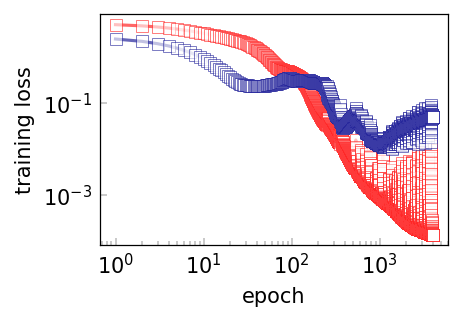

In [10]:
figure, ax = plt.subplots(dpi=150, figsize=(3, 2.))

# Log-log plot of training loss history
ax.loglog(np.arange(1, len(training_loss_hist) + 1, 1), # epochs
          training_loss_hist,
          marker='s', markersize=6, markeredgecolor='red', markeredgewidth=0.4, markerfacecolor='white',  
          linestyle='-', alpha = 0.6, color='red')
# Log-log plot of validation loss history
ax.loglog(np.arange(1, len(validation_loss_hist) + 1, 1), # epochs
          validation_loss_hist,
          marker='s', markersize=6, markeredgecolor='darkblue', markeredgewidth=0.4, markerfacecolor='white',  # Hollow red markers
          linestyle='-', alpha = 0.6, color='darkblue')  # Solid black line connecting points
# Axis labels
ax.set_xlabel("epoch")
ax.set_ylabel("training loss")
# Show plot
plt.show()

### 4. Inference

#### 4.1 Predict the initial conditions for the elastic strain given the stress state

In [11]:
from scipy.optimize import root
# Solve for initial elastic strain using a root-finding method
solution = root(NICE_network.find_elastic_strain,
                args=([initial_density, initial_stress.reshape(-1, 2)]),
                x0=np.zeros((len(n_train_val), 2)),  # Initial guess for elastic strain
                tol=1e-12)  # High precision tolerance

# Convert solution to PyTorch tensor
norm_initial_elastic_strain = torch.from_numpy(solution.x.reshape(-1, 2))

# De-normalizing the computed elastic strain to its physical scale
initial_elastic_strain = NICE_network.DeNormalize(norm_initial_elastic_strain, NICE_network.prm_strain_elastic)

#### 4.2 Predict the material response under strain-driven protocol

In [12]:
# Creating the full state variable input for the NICE network
initial_conditions = torch.cat((initial_elastic_strain, initial_density, initial_dissipation), -1)

# Predicting the stress evolution with the NICE network
predictions = NICE_network.integrate(initial_conditions, t, id_protocol_train_val)

# Extracting the predicted state variables, stress, and dissipation
predicted_svars, predicted_stress, predicted_dissipation = predictions

#### 4.3 Predictions versus real experiments (stress-strain response)

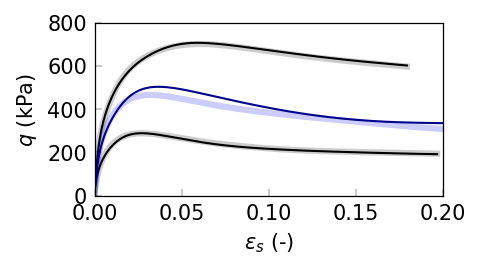

In [13]:
figure, ax = plt.subplots(dpi=150, figsize=(3, 1.5))
    
# Loop over protocols in the training set
for i, protocol in enumerate(n_train):
    # Plot ground truth
    ax.plot(strain_train_val[:, protocol, 1].detach().numpy(),
            stress_train_val[:, protocol, 1].detach().numpy(),
            linewidth=3, alpha=0.2, color='black',
            label="Ground Truth" if i == 0 else "")

    # Plot model-predicted stress-strain curve
    ax.plot(strain_train_val[:, protocol, 1].detach().numpy(),
            predicted_stress[:, protocol, 1].detach().numpy(),
            linewidth=1, color='black',
            label="Predicted" if i == 0 else "")

# Loop over protocols in the validation set
for i, protocol in enumerate(n_val):
    # Plot ground truth
    ax.plot(strain_train_val[:, protocol, 1].detach().numpy(),
            stress_train_val[:, protocol, 1].detach().numpy(),
            linewidth=3, alpha=0.2, color='blue',
            label="Ground Truth" if i == 0 else "")

    # Plot model-predicted stress-strain curve
    ax.plot(strain_train_val[:, protocol, 1].detach().numpy(),
            predicted_stress[:, protocol, 1].detach().numpy(),
            linewidth=1, color='darkblue',
            label="Predicted" if i == 0 else "")

ax.set_ylim(0, 800)  # Limit for q (kPa)
ax.set_xlim(0, 0.2)  # Limit for strain
ax.set_ylabel(r'$q$ (kPa)')  # Stress variable label
ax.set_xlabel(r'$\varepsilon_s$ (-)')  # Strain variable label    
plt.show()

### 4.4 Thermodynamics consistency: dissipation and dissipation rate

0
1
0


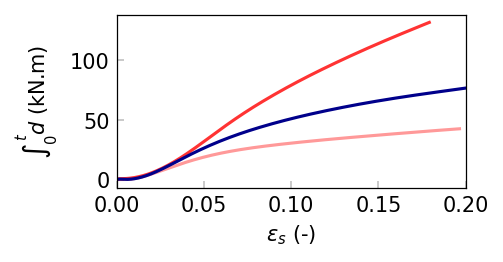

In [14]:
figure, ax = plt.subplots(dpi=150, figsize=(3, 1.5))
# Loop through training protocols
for i, protocol in enumerate(n_train):
    print(i)
    ax.plot(strain_train_val[:, protocol, 1].detach().numpy(),
            predicted_dissipation[:, protocol, 0].detach().numpy(),
            alpha=0.4*i+0.4, color='red',
            label="Predicted Dissipation" if i == 0 else "")  
for i, protocol in enumerate(n_val):
    print(i)
    ax.plot(strain_train_val[:, protocol, 1].detach().numpy(),
            predicted_dissipation[:, protocol, 0].detach().numpy(),
            alpha=1, color='darkblue',
            label="Predicted Dissipation" if i == 0 else "")  

ax.set_xlim(0, 0.2)
ax.set_ylabel('$\int_0^t d $ (kN.m)')
ax.set_xlabel(r'$\varepsilon_s$ (-)')
plt.show()

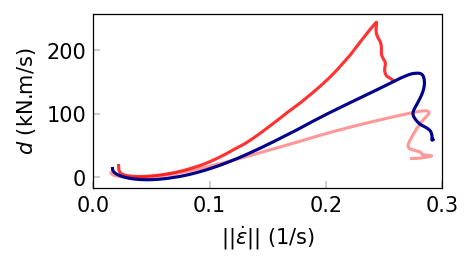

In [15]:
predicted_dissipation_rate = (predicted_dissipation[1:] - predicted_dissipation[:-1]) / dt
figure, ax = plt.subplots(dpi=150, figsize=(3, 1.5))
# Loop through training protocols
for i, protocol in enumerate(n_train):
    ax.plot(np.linalg.norm(strain_rate[:-1, protocol],axis=-1,ord=None),
            predicted_dissipation_rate[:, protocol, 0].detach().numpy(),
            alpha=0.4*i+0.4, color='red',
            label="Predicted Dissipation" if i == 0 else "") 
# Loop through validation protocols
for i, protocol in enumerate(n_val):
    ax.plot(np.linalg.norm(strain_rate[:-1, protocol],axis=-1,ord=None),
            predicted_dissipation_rate[:, protocol, 0].detach().numpy(),
            alpha=1, color='darkblue',
            label="Predicted Dissipation" if i == 0 else "") 
ax.set_xlim(0, 0.3)
ax.set_ylabel('$d$ (kN.m/s)')
ax.set_xlabel(r'$|| \dot{\varepsilon}||$ (1/s)')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=943eba7c-6248-4f0d-a7d4-57f7be1179ac' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>